# Effective DOF test

## Import package

In [1]:
import numpy as np
import netCDF4 as nc

from scipy import stats
from matplotlib.colors import TwoSlopeNorm
from matplotlib import pyplot as plt

## Load data

In [2]:
# Load MPAS data
## dimension
import time


dims: dict[str, np.ndarray] = dict()

moisture: dict[str, np.ndarray] = dict()


## variables
with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/CNTL/qv.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:]

    lat_lim: list[int] = np.where((dims["lat"][:] >= -5) & (dims["lat"][:] <= 5))[0]

    moisture["CNTL"] = f.variables["qv"][:, :, lat_lim, :].mean(axis=2) * 1000

with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/NCRF/qv.nc", "r") as f:
    moisture["NCRF"] = f.variables["qv"][:, :, lat_lim, :].mean(axis=2) * 1000

with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/NSC/qv.nc", "r") as f:
    moisture["NSC"] = f.variables["qv"][:, :, lat_lim, :].mean(axis=2) * 1000


ltime, llev, llon = moisture["NSC"].shape

# load events
lon_ref: dict[str, np.ndarray] = dict()
time_ref: dict[str, np.ndarray] = dict()

for key in moisture.keys():
    lon_ref[key], time_ref[key] = np.load(
        f"/home/b11209013/2024_Research/MPAS/Composite/Q1_event_sel/Q1_sel/{key}.npy"
    )


### Acquiring anomaly

In [3]:
for key in moisture.keys():
    moisture[key] -= moisture[key].mean(axis=(0, 2))[None, :, None]

## Systematic Event selection

### Time interval setting

In [4]:
time_itv: dict[str, np.ndarray] = dict()

for key in moisture.keys():
    time_itv[key] = np.array([
        np.linspace(time_ref[key][i]-12, time_ref[key][i]+12, 25)
        for i in range(time_ref[key].shape[0])
    ])


### Event selection

In [5]:
temp_sel: dict[str, np.ndarray] = dict()

for key in moisture.keys():
    temp_sel[key] = np.array([
        moisture[key][time_itv[key][i].astype(int), :, lon_ref[key][i].astype(int)]
        for i in range(time_ref[key].shape[0])
    ])
    
print(temp_sel["CNTL"].shape)

(15, 25, 38)


### Compositing

In [6]:
temp_diff_ncrf: np.ndarray = (temp_sel["CNTL"].mean(axis=0) - temp_sel["NCRF"].mean(axis=0)).T
temp_diff_nsc : np.ndarray = (temp_sel["CNTL"].mean(axis=0) - temp_sel["NSC"].mean(axis=0)).T

## Bootstrapping

### Generate random points

In [7]:
# generate random points
lon_rand : np.ndarray = np.random.randint(0, llon-1, 26000).reshape(1000, 26)
time_rand: np.ndarray = np.random.randint(13, ltime-13, 26000)

# setting time interval
time_itv_rand: np.ndarray = np.array([
    np.linspace(time_rand[i]-12, time_rand[i]+12, 25, dtype=int)
    for i in range(time_rand.shape[0])
]).reshape(26, 1000, 25).transpose(1, 0, 2)

print("Random lon size:", lon_rand.shape)
print("Random time interval size:", time_itv_rand.shape)

Random lon size: (1000, 26)
Random time interval size: (1000, 26, 25)


### Select random events

In [8]:
temp_diff_rand_ncrf: np.ndarray = np.empty((1000, 38, 25))
temp_diff_rand_nsc : np.ndarray = np.empty((1000, 38, 25))

for i in range(time_itv_rand.shape[0]):
    
    temp_CNTL = np.array([
        moisture["CNTL"][time_itv_rand[i, j].astype(int), :, lon_rand[i, j].astype(int)].T
        for j in range(time_itv_rand.shape[1])
    ]).mean(axis=0)
    
    temp_NCRF = np.array([
        moisture["NCRF"][time_itv_rand[i, j].astype(int), :, lon_rand[i, j].astype(int)].T
        for j in range(time_itv_rand.shape[1])
    ]).mean(axis=0)

    temp_NSC = np.array([
        moisture["NSC"][time_itv_rand[i, j].astype(int), :, lon_rand[i, j].astype(int)].T
        for j in range(time_itv_rand.shape[1])
    ]).mean(axis=0)
    
    temp_diff_rand_ncrf[i] = temp_CNTL - temp_NCRF
    temp_diff_rand_nsc[i] = temp_CNTL - temp_NSC

print("Random temperature difference shape:", temp_diff_rand_nsc.shape)

Random temperature difference shape: (1000, 38, 25)


## Statistic test

### CNTL vs. NCRF

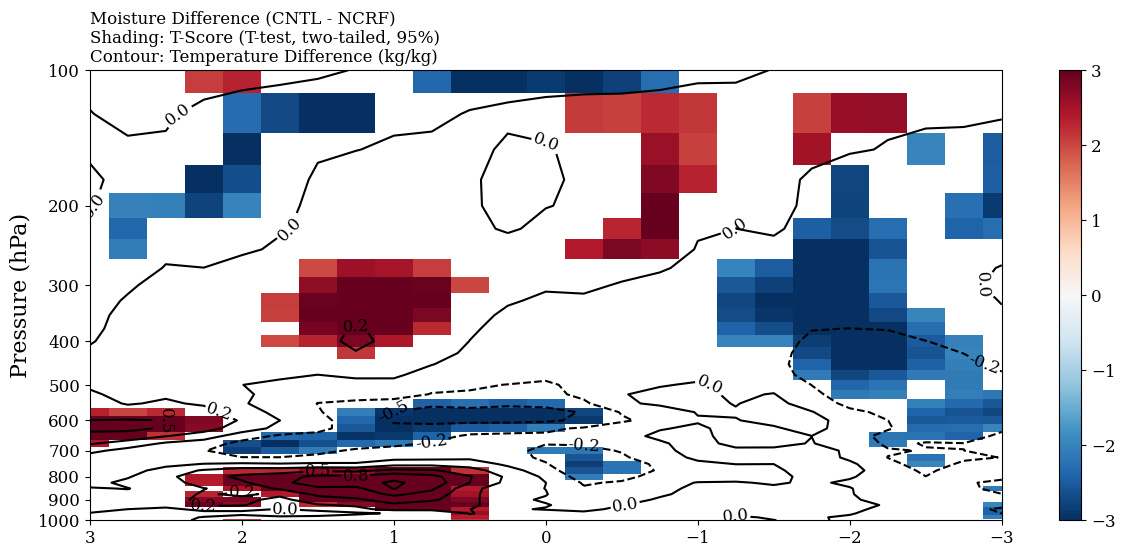

In [9]:
# mean and standard deviation
temp_diff_mean_ncrf: np.ndarray = temp_diff_rand_ncrf.mean(axis=0)
temp_diff_std_ncrf : np.ndarray = temp_diff_rand_ncrf.std(axis=0)


temp_diff_t_ncrf: np.ndarray = (temp_diff_ncrf - temp_diff_mean_ncrf) / temp_diff_std_ncrf

temp_diff_t_ncrf = np.where(np.abs(temp_diff_t_ncrf) > 1.96, temp_diff_t_ncrf, np.nan)

plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=1.05, top=0.85, bottom=0.1)
cf = ax.pcolormesh(np.linspace(-3, 3, 25), dims["lev"], temp_diff_t_ncrf, cmap="RdBu_r", norm=TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3))
c = ax.contour(np.linspace(-3, 3, 25), dims["lev"], temp_diff_ncrf, colors="black")
ax.set_yscale("log")
ax.set_yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
ax.set_xlim(-3, 3)
ax.set_ylim(100, 1000)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax.set_ylabel("Pressure (hPa)")
ax.set_title("Moisture Difference (CNTL - NCRF)\nShading: T-Score (T-test, two-tailed, 95%)\nContour: Temperature Difference (kg/kg)", fontsize=12, loc="left")
plt.clabel(c, inline=True, fmt="%.1f")
plt.colorbar(cf)
plt.savefig("Moisture_diff/t_cntl_ncrf.png", dpi=300)

### CNTL vs. NSC

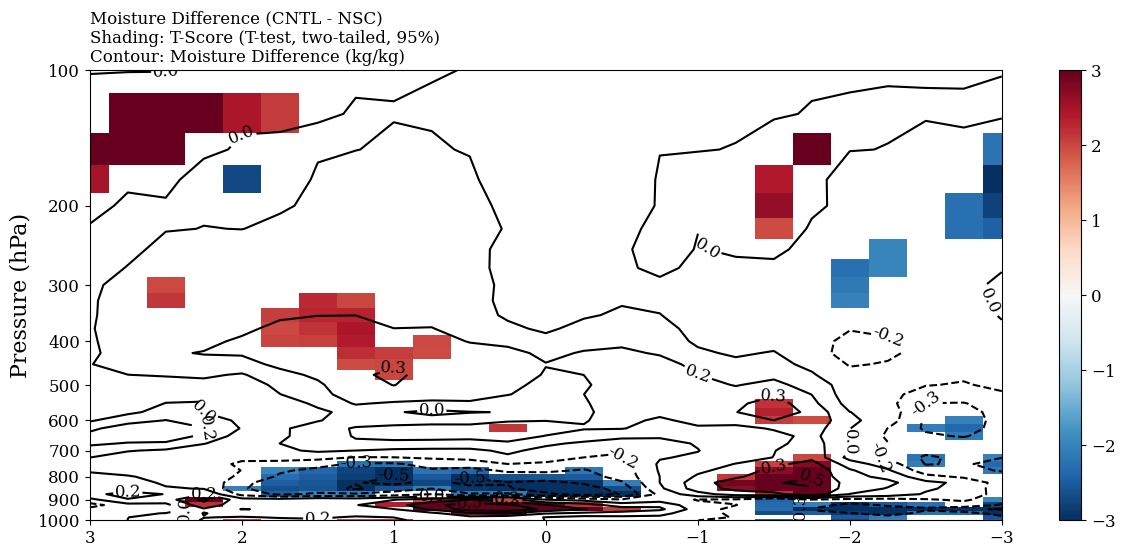

In [10]:
# mean and standard deviation
temp_diff_mean_nsc: np.ndarray = temp_diff_rand_nsc.mean(axis=0)
temp_diff_std_nsc : np.ndarray = temp_diff_rand_nsc.std(axis=0)


temp_diff_t_nsc: np.ndarray = (temp_diff_nsc - temp_diff_mean_nsc) / temp_diff_std_nsc

temp_diff_t_nsc = np.where(np.abs(temp_diff_t_nsc) > 1.96, temp_diff_t_nsc, np.nan)

fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=1.05, top=0.85, bottom=0.1)
cf = ax.pcolormesh(np.linspace(-3, 3, 25), dims["lev"], temp_diff_t_nsc, cmap="RdBu_r", norm=TwoSlopeNorm(vmin=-3, vcenter=0, vmax=3))
c = ax.contour(np.linspace(-3, 3, 25), dims["lev"], temp_diff_nsc, colors="black")
ax.set_yscale("log")
ax.set_yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
ax.set_xlim(-3, 3)
ax.set_ylim(100, 1000)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax.set_ylabel("Pressure (hPa)")
ax.set_title("Moisture Difference (CNTL - NSC)\nShading: T-Score (T-test, two-tailed, 95%)\nContour: Moisture Difference (kg/kg)", fontsize=12, loc="left")
plt.clabel(c, inline=True, fmt="%.1f")
plt.colorbar(cf)
plt.savefig("Moisture_diff/t_cntl_nsc.png", dpi=300)

## Temperature profile

### CNTL vs. NCRF

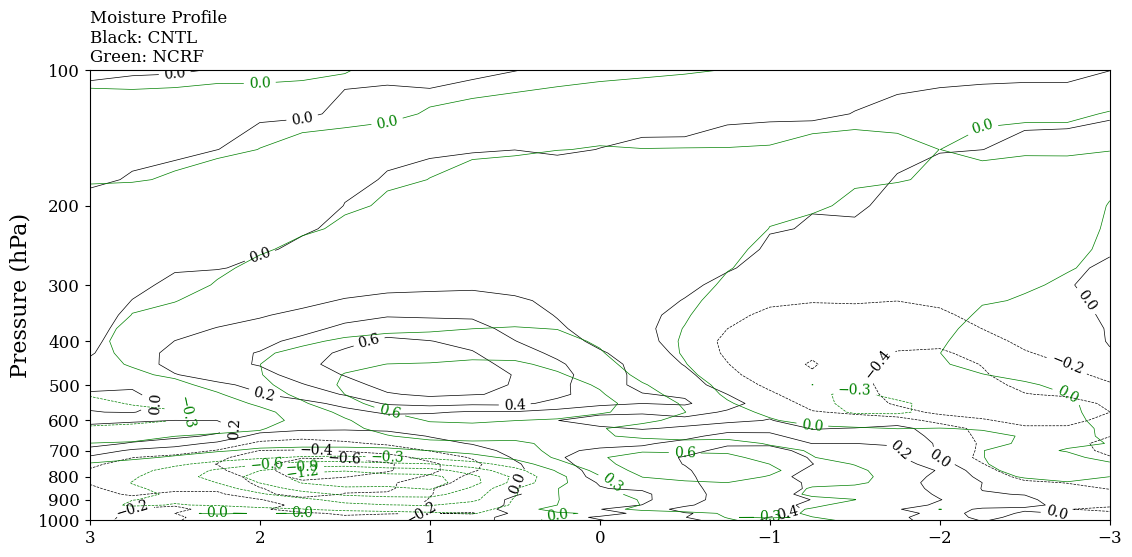

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.95, top=0.85, bottom=0.1)
c_cntl = ax.contour(np.linspace(-3, 3, 25), dims["lev"], temp_sel["CNTL"].mean(axis=0).T, colors="black", linewidths=0.5)
c_ncrf = ax.contour(np.linspace(-3, 3, 25), dims["lev"], temp_sel["NCRF"].mean(axis=0).T, colors="green", linewidths=0.5)
ax.set_yscale("log")
ax.set_yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax.set_ylabel("Pressure (hPa)")
ax.set_title("Moisture Profile\nBlack: CNTL\nGreen: NCRF", fontsize=12, loc="left")
plt.clabel(c_cntl, inline=True, fontsize=10)
plt.clabel(c_ncrf, inline=True, fontsize=10)
plt.savefig("Moisture_diff/cntl_ncrf.png", dpi=300)

### CNTL vs. NSC

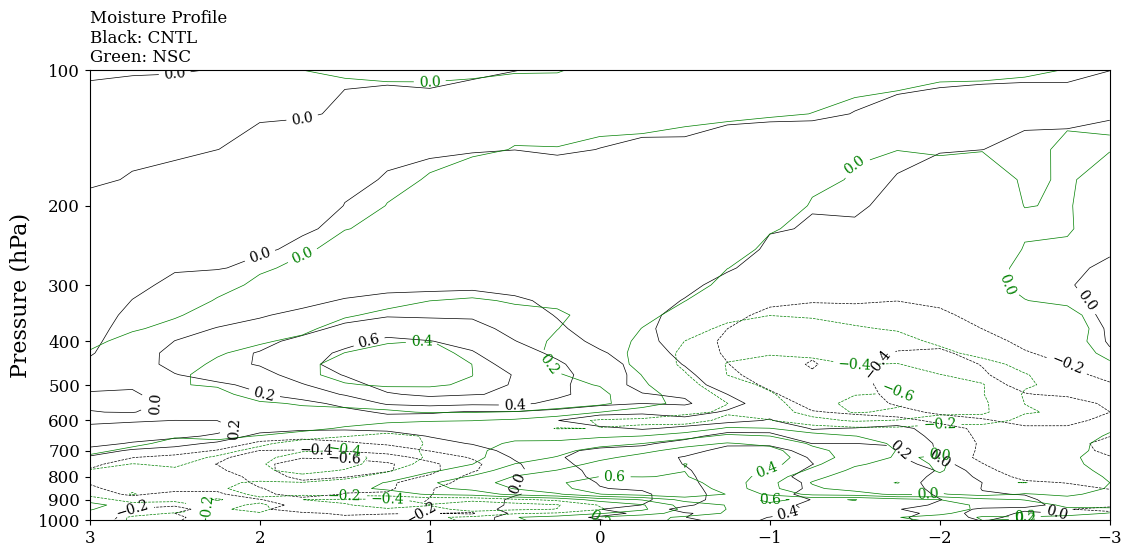

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(left=0.1, right=0.95, top=0.85, bottom=0.1)
c_cntl = ax.contour(np.linspace(-3, 3, 25), dims["lev"], temp_sel["CNTL"].mean(axis=0).T, colors="black", linewidths=0.5)
c_ncrf = ax.contour(np.linspace(-3, 3, 25), dims["lev"], temp_sel["NSC"].mean(axis=0).T, colors="green", linewidths=0.5)
ax.set_yscale("log")
ax.set_yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
ax.set_ylabel("Pressure (hPa)")
ax.set_title("Moisture Profile\nBlack: CNTL\nGreen: NSC", fontsize=12, loc="left")
plt.clabel(c_cntl, inline=True, fontsize=10)
plt.clabel(c_ncrf, inline=True, fontsize=10)
plt.savefig("Moisture_diff/cntl_nsc.png", dpi=300)